# 6. Reinforcement Learning: The inverted pendulum

In [5]:
# %load 'cart_pole.py'
"""
CS 229 Machine Learning, Fall 2017
Problem Set 4
Question: Reinforcement Learning: The inverted pendulum
Author: Sanyam Mehra, sanyam@stanford.edu
"""
from __future__ import division, print_function
from math import sin, cos, pi
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class CartPole:
    def __init__(self, physics):
        self.physics = physics
        self.mass_cart = 1.0
        self.mass_pole = 0.3
        self.mass = self.mass_cart + self.mass_pole
        self.length = 0.7 # actually half the pole length
        self.pole_mass_length = self.mass_pole * self.length

    def simulate(self, action, state_tuple):
        """
        Simulation dynamics of the cart-pole system

        Parameters
        ----------
        action : int
            Action represented as 0 or 1
        state_tuple : tuple
            Continuous vector of x, x_dot, theta, theta_dot

        Returns
        -------
        new_state : tuple
            Updated state vector of new_x, new_x_dot, nwe_theta, new_theta_dot
        """
        x, x_dot, theta, theta_dot = state_tuple
        costheta, sintheta = cos(theta), sin(theta)
        # costheta, sintheta = cos(theta * 180 / pi), sin(theta * 180 / pi)

        # calculate force based on action
        force = self.physics.force_mag if action > 0 else (-1 * self.physics.force_mag)

        # intermediate calculation
        temp = (force + self.pole_mass_length * theta_dot * theta_dot * sintheta) / self.mass
        theta_acc = (self.physics.gravity * sintheta - temp * costheta) / (self.length * (4/3 - self.mass_pole * costheta * costheta / self.mass))

        x_acc = temp - self.pole_mass_length * theta_acc * costheta / self.mass

        # return new state variable using Euler's method
        new_x = x + self.physics.tau * x_dot
        new_x_dot = x_dot + self.physics.tau * x_acc
        new_theta = theta + self.physics.tau * theta_dot
        new_theta_dot = theta_dot + self.physics.tau * theta_acc
        new_state = (new_x, new_x_dot, new_theta, new_theta_dot)

        return new_state

    def get_state(self, state_tuple):
        """
        Discretizes the continuous state vector. The current discretization
        divides x into 3, x_dot into 3, theta into 6 and theta_dot into 3
        categories. A finer discretization produces a larger state space
        but allows for a better policy

        Parameters
        ----------
        state_tuple : tuple
            Continuous vector of x, x_dot, theta, theta_dot

        Returns
        -------
        state : int
            Discretized state value
        """
        x, x_dot, theta, theta_dot = state_tuple
        # parameters for state discretization in get_state
        # convert degrees to radians
        one_deg = pi / 180
        six_deg = 6 * pi / 180
        twelve_deg = 12 * pi / 180
        fifty_deg = 50 * pi / 180

        total_states = 163
        state = 0

        if x < -2.4 or x > 2.4 or theta < -twelve_deg or theta > twelve_deg:
            state = total_states - 1 # to signal failure
        else:
            # x: 3 categories
            if x < -1.5:
                state = 0
            elif x < 1.5:
                state = 1
            else:
                state = 2
            # x_dot: 3 categories
            if x_dot < -0.5:
                pass
            elif x_dot < 0.5:
                state += 3
            else:
                state += 6
            # theta: 6 categories
            if theta < -six_deg:
                pass
            elif theta < -one_deg:
                state += 9
            elif theta < 0:
                state += 18
            elif theta < one_deg:
                state += 27
            elif theta < six_deg:
                state += 36
            else:
                state += 45
            # theta_dot: 3 categories
            if theta_dot < -fifty_deg:
                pass
            elif theta_dot < fifty_deg:
                state += 54
            else:
                state += 108
        # state += 1 # converting from MATLAB 1-indexing to 0-indexing
        return state

    def show_cart(self, state_tuple, pause_time):
        """
        Given the `state_tuple`, displays the cart-pole system.

        Parameters
        ----------
        state_tuple : tuple
            Continuous vector of x, x_dot, theta, theta_dot
        pause_time : float
            Time delay in seconds

        Returns
        -------
        """
        x, x_dot, theta, theta_dot = state_tuple
        X = [x, x + 4*self.length * sin(theta)]
        Y = [0, 4*self.length * cos(theta)]
        plt.close('all')
        fig, ax = plt.subplots(1)
        plt.ion()
        ax.set_xlim(-3, 3)
        ax.set_ylim(-0.5, 3.5)
        ax.plot(X, Y)
        cart = patches.Rectangle((x - 0.4, -0.25), 0.8, 0.25,
                        linewidth=1, edgecolor='k', facecolor='cyan')
        base = patches.Rectangle((x - 0.01, -0.5), 0.02, 0.25,
                        linewidth=1, edgecolor='k', facecolor='r')
        ax.add_patch(cart)
        ax.add_patch(base)
        x_dot_str, theta_str, theta_dot_str = '\\dot{x}', '\\theta', '\\dot{\\theta}'
        ax.set_title('x: %.3f, $%s$: %.3f, $%s$: %.3f, $%s$: %.3f'\
                                %(x, x_dot_str, x_dot, theta_str, theta, theta_dot_str, x))
        plt.show()
        plt.pause(pause_time)

class Physics:
    gravity = 9.8
    force_mag = 10.0
    tau = 0.02 # seconds between state updates


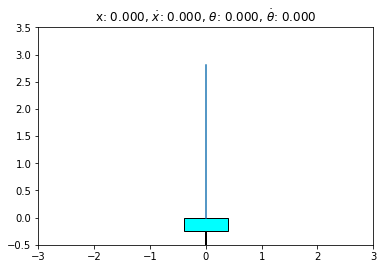

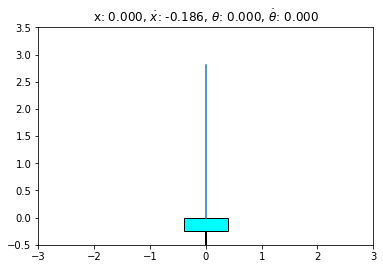

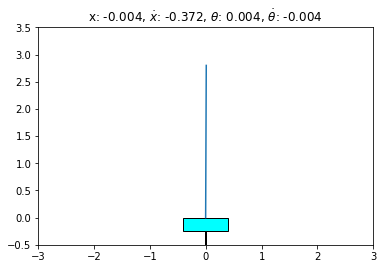

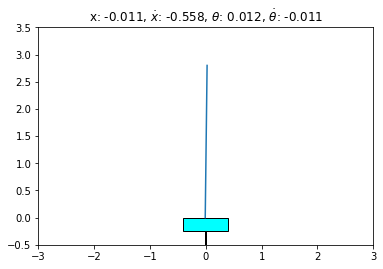

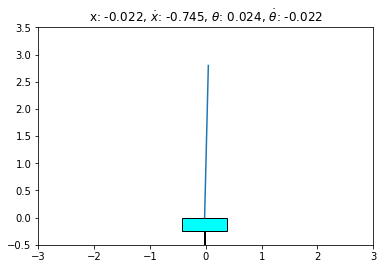

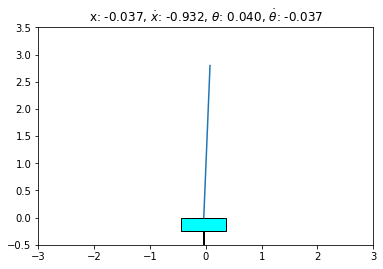

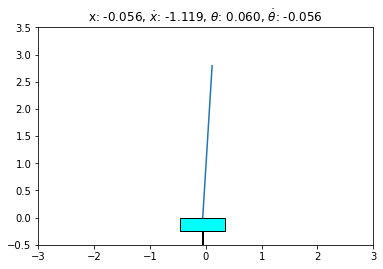

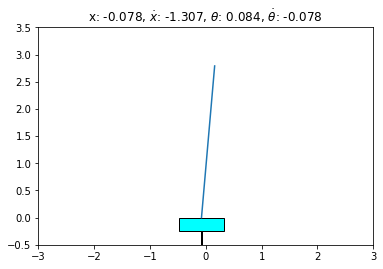

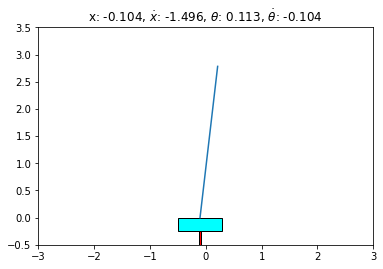

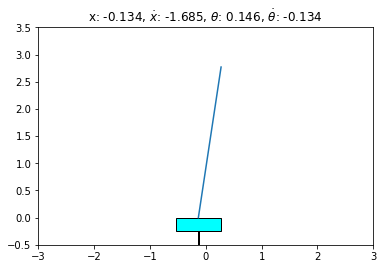

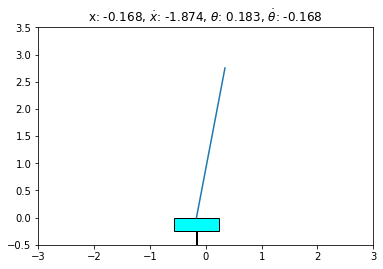

[INFO] Failure number 1


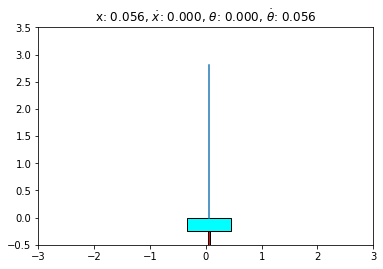

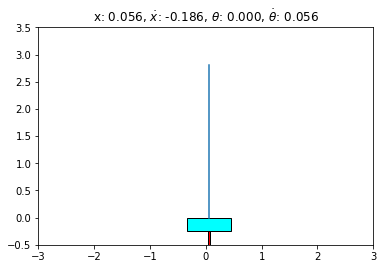

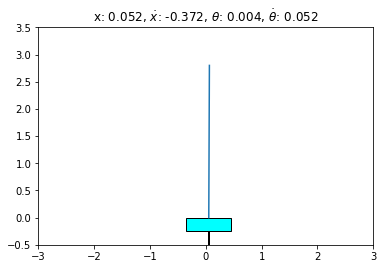

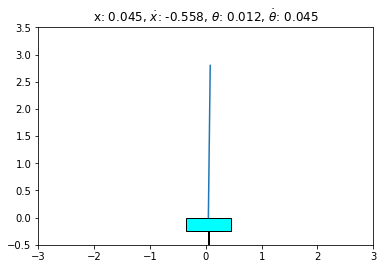

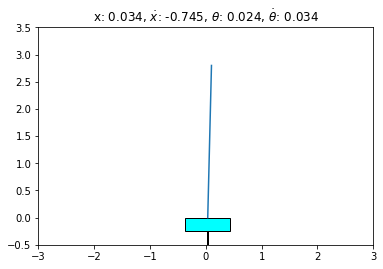

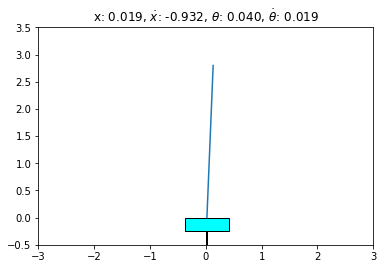

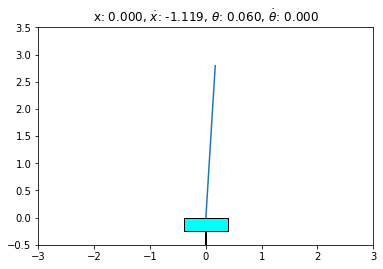

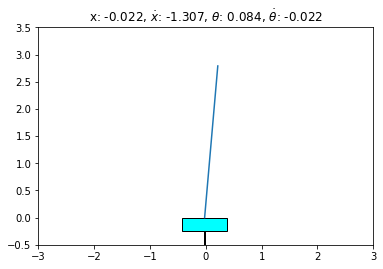

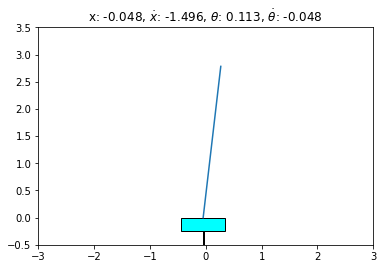

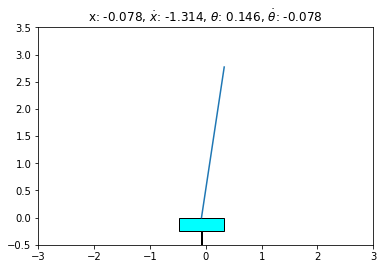

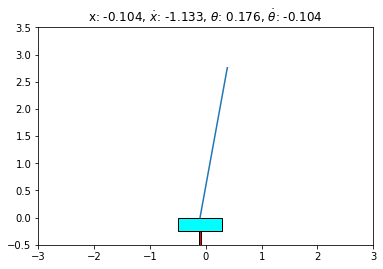

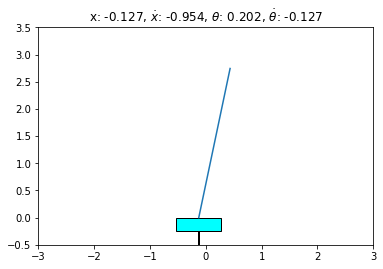

[INFO] Failure number 2


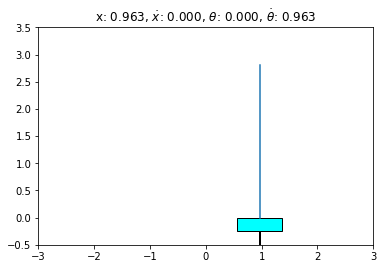

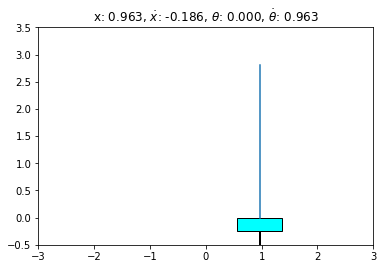

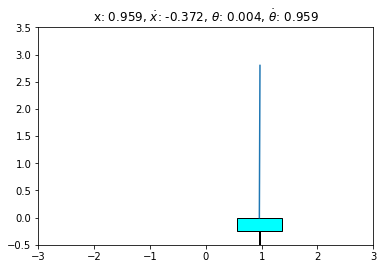

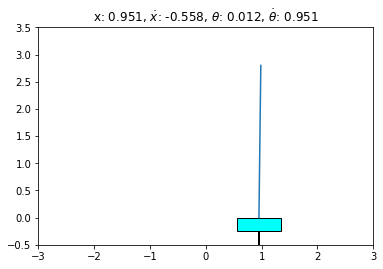

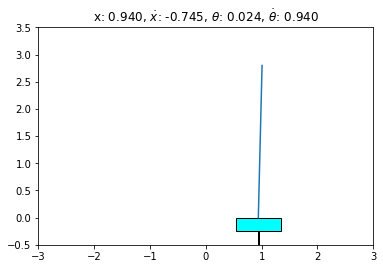

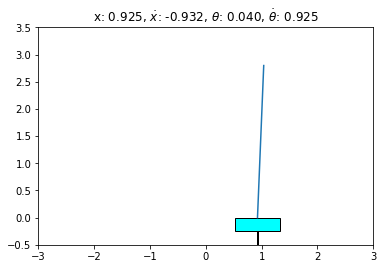

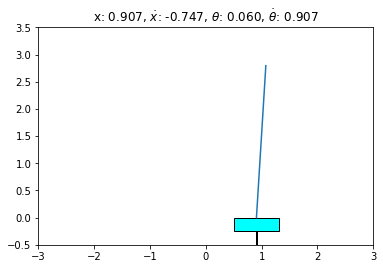

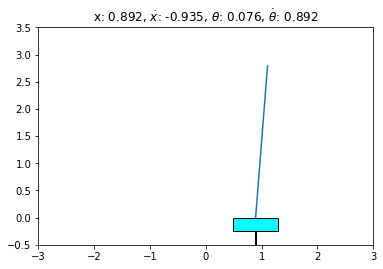

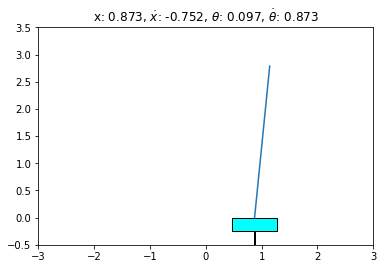

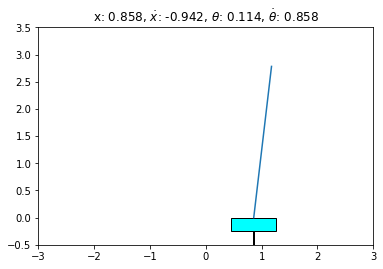

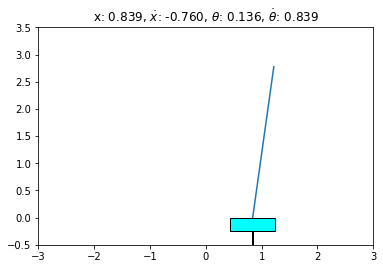

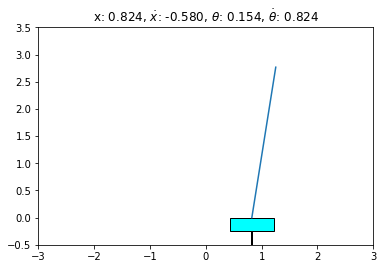

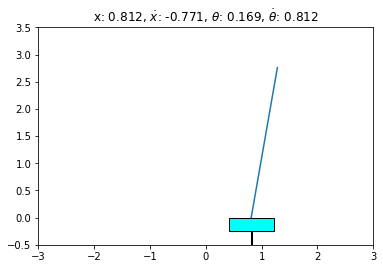

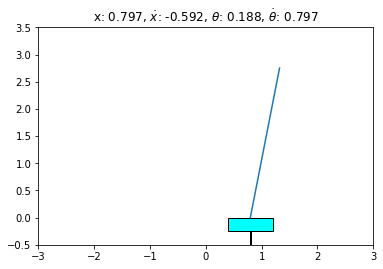

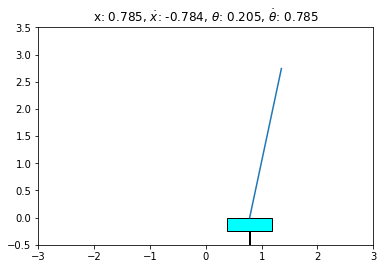

[INFO] Failure number 3


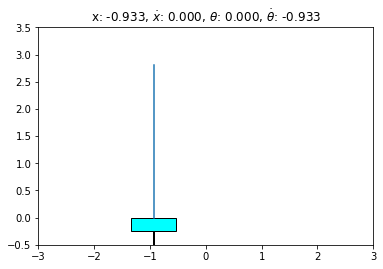

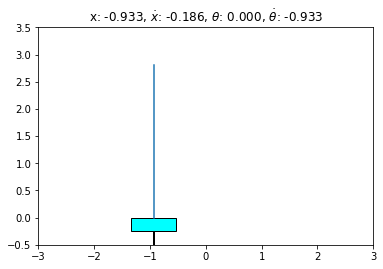

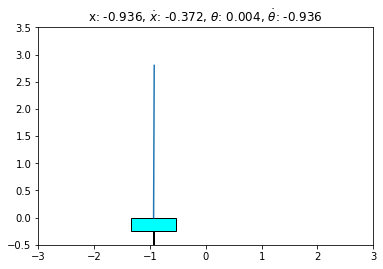

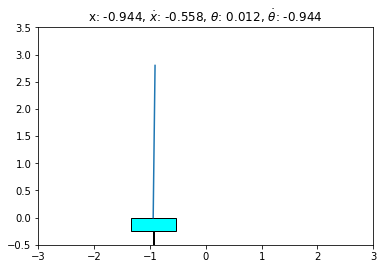

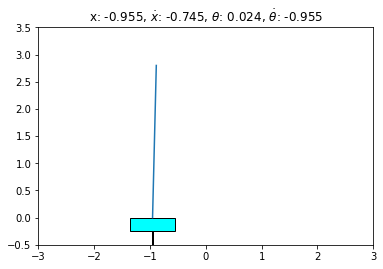

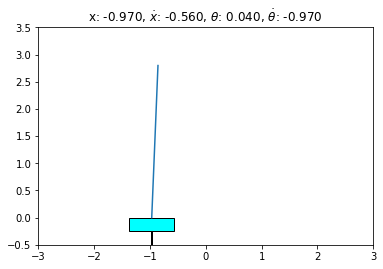

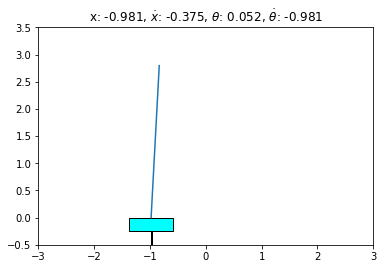

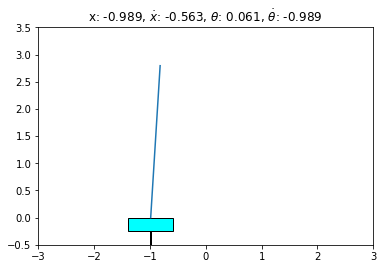

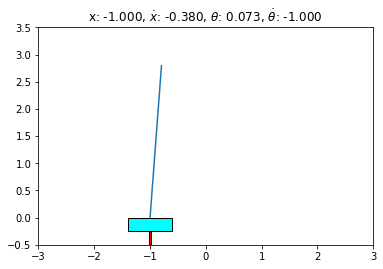

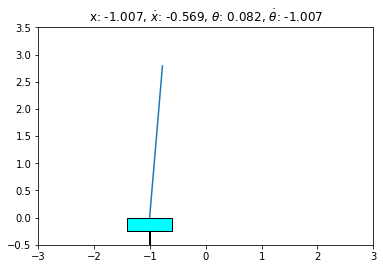

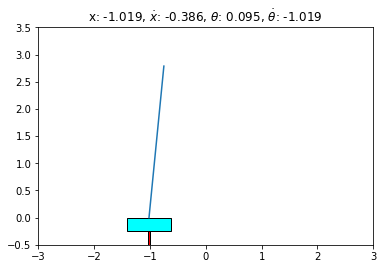

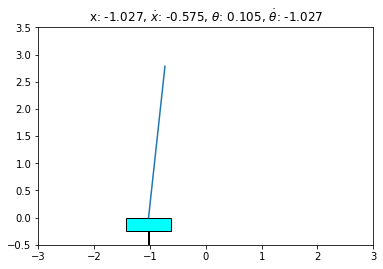

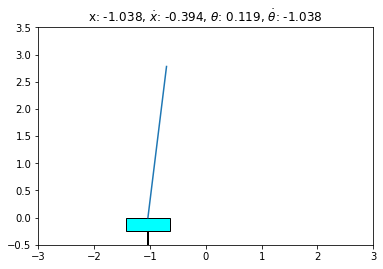

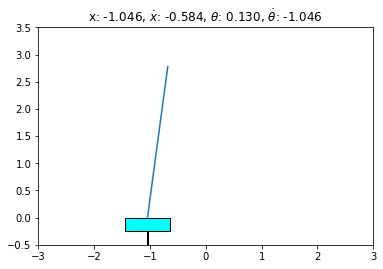

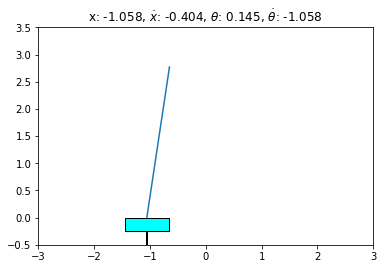

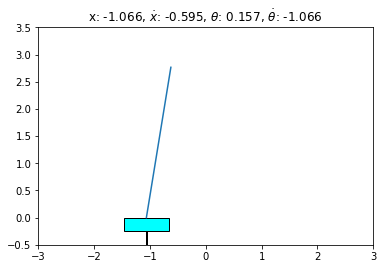

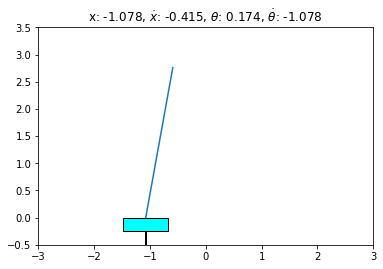

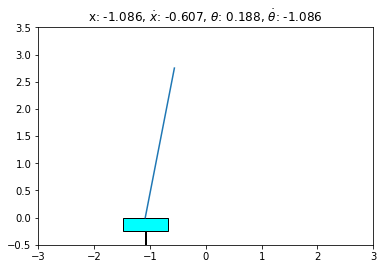

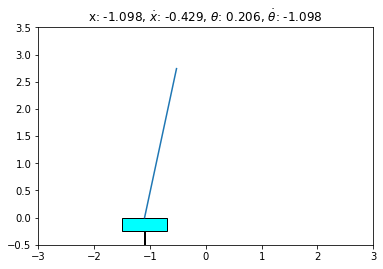

[INFO] Failure number 4


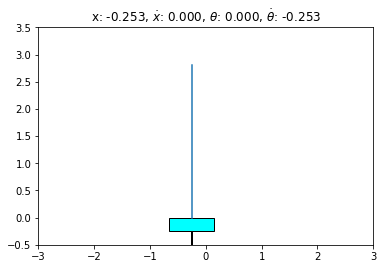

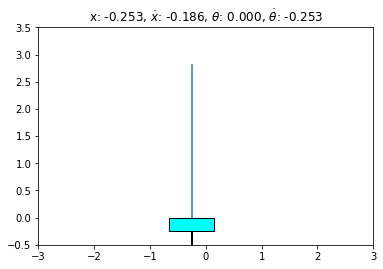

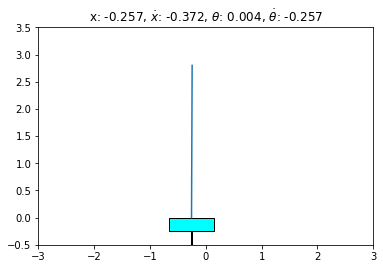

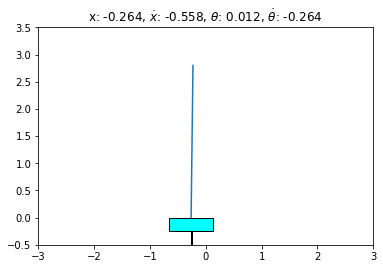

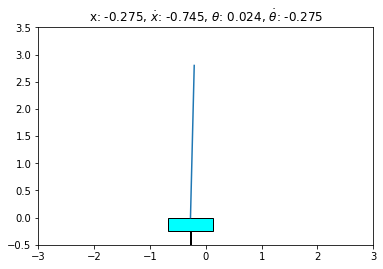

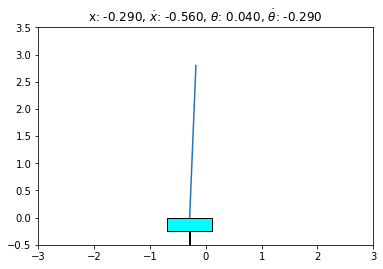

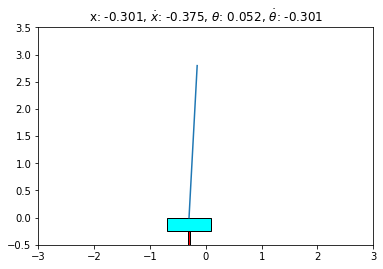

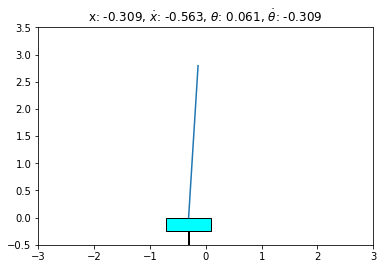

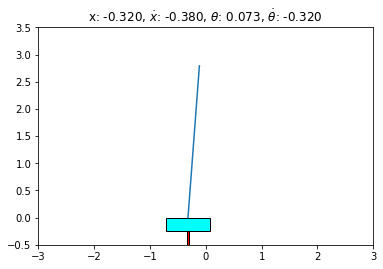

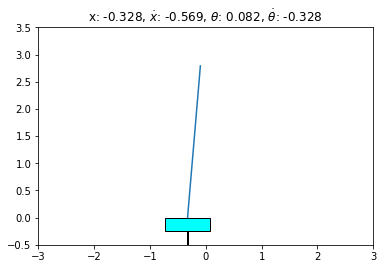

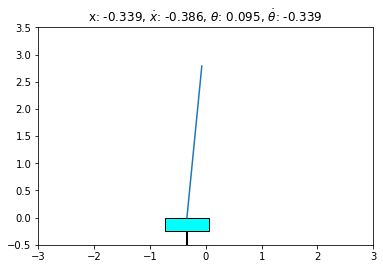

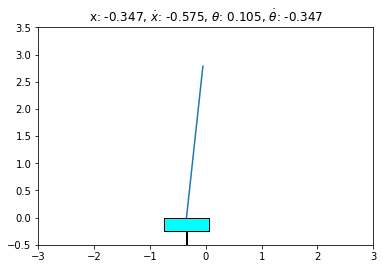

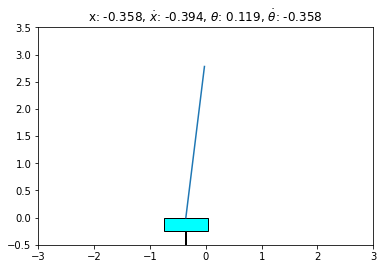

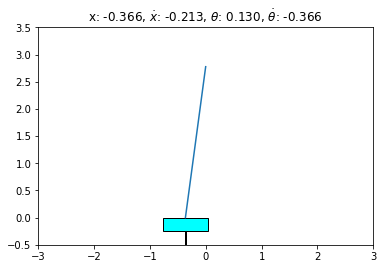

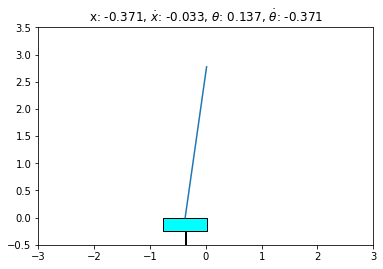

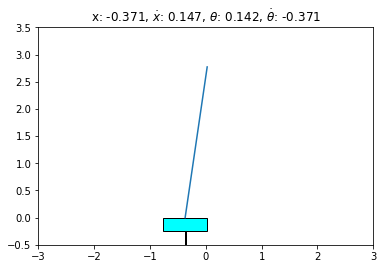

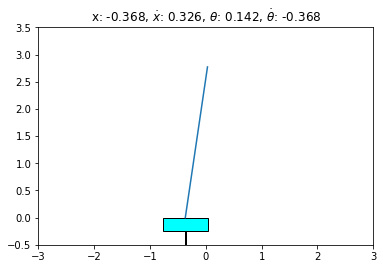

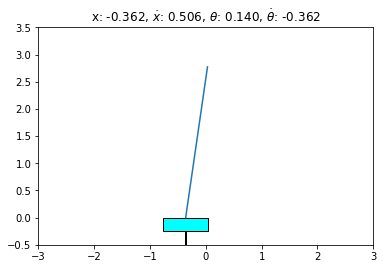

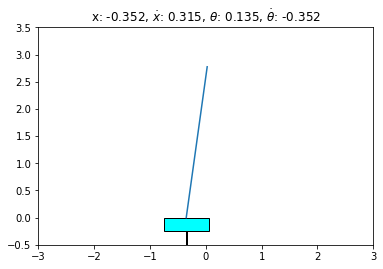

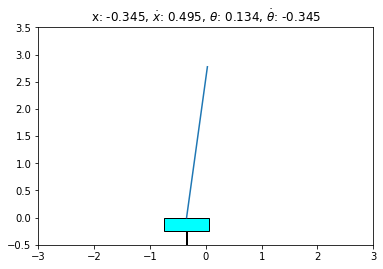

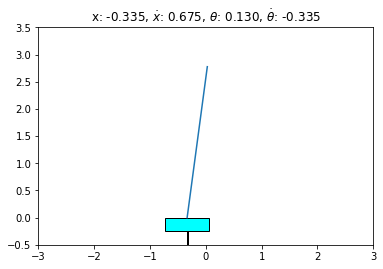

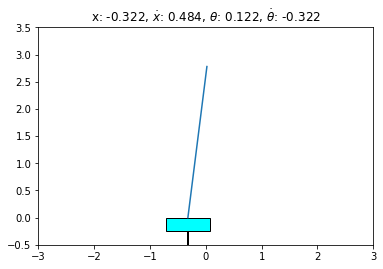

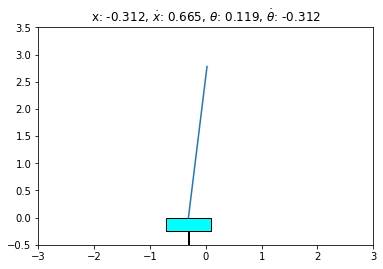

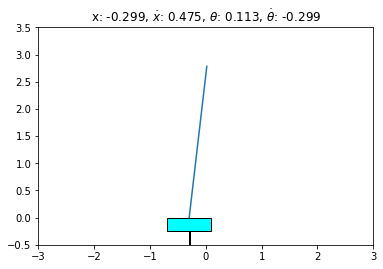

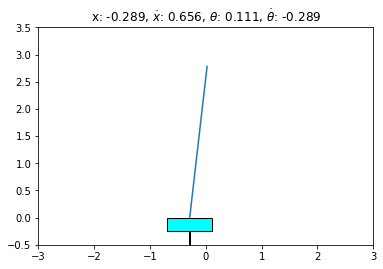

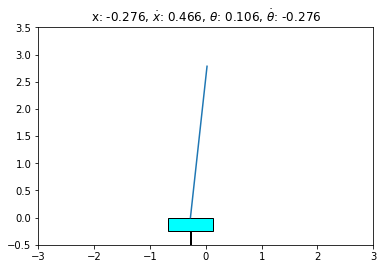

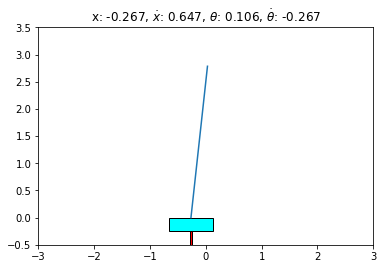

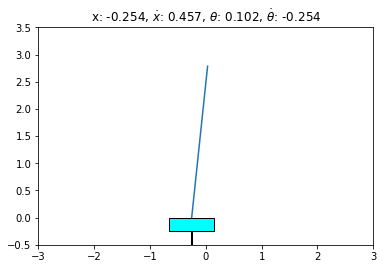

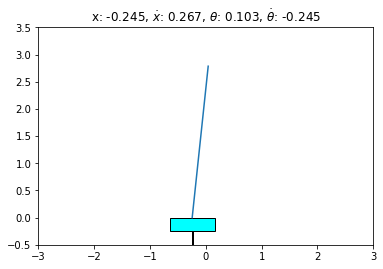

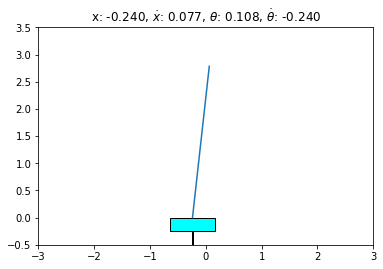

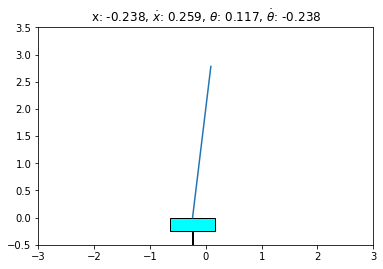

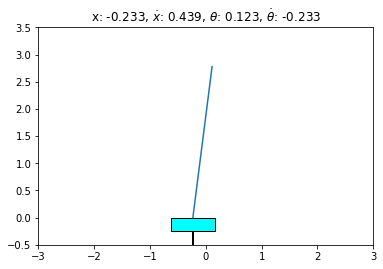

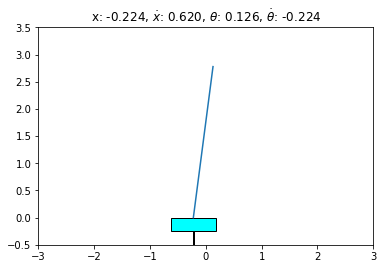

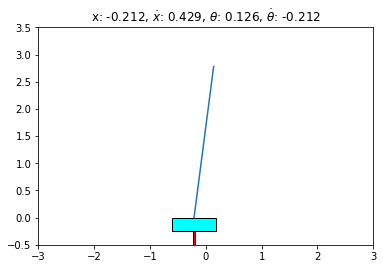

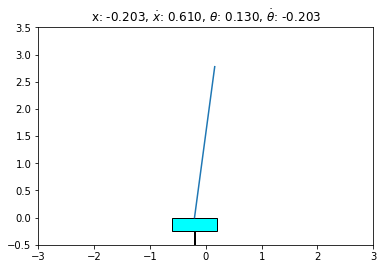

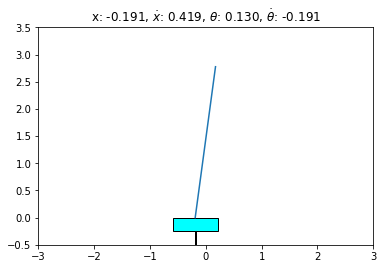

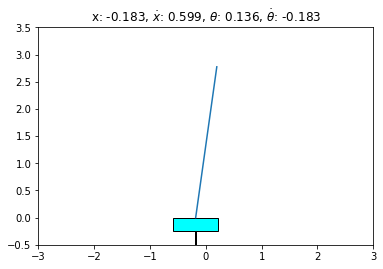

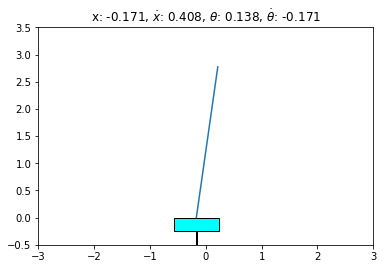

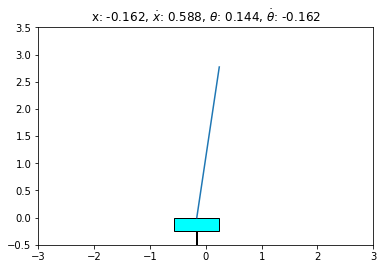

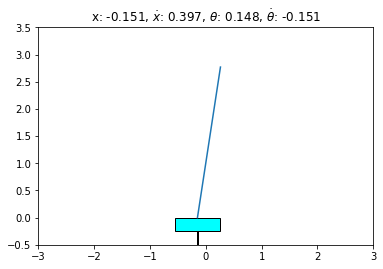

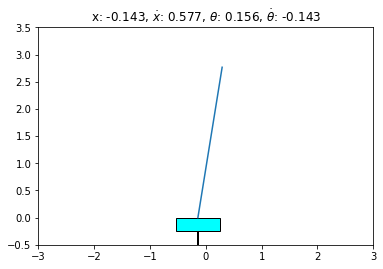

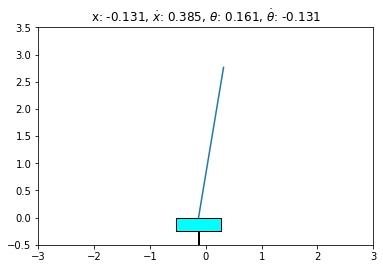

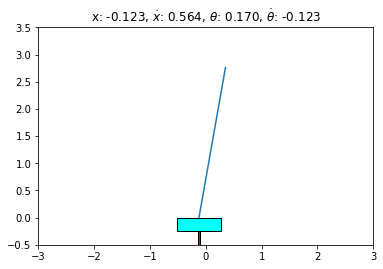

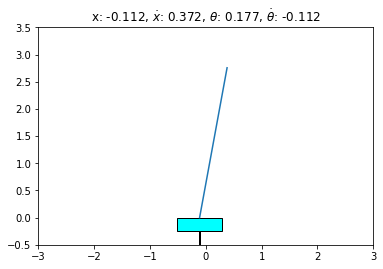

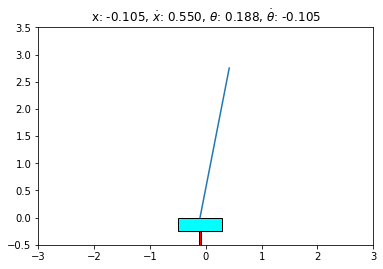

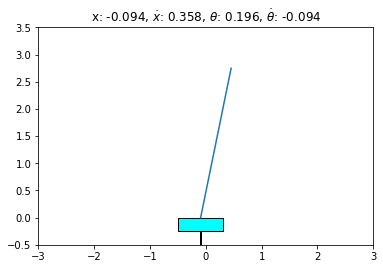

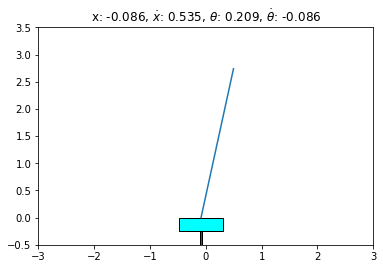

[INFO] Failure number 5


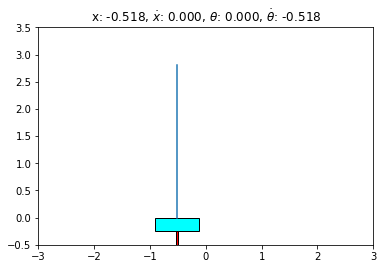

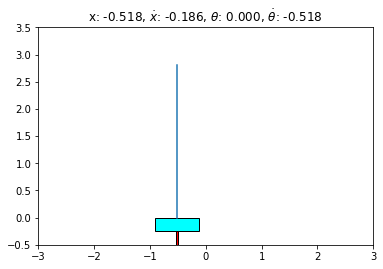

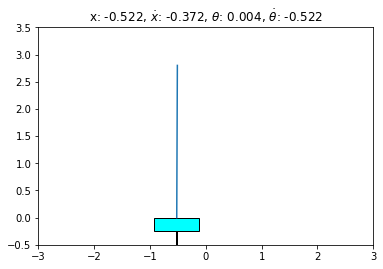

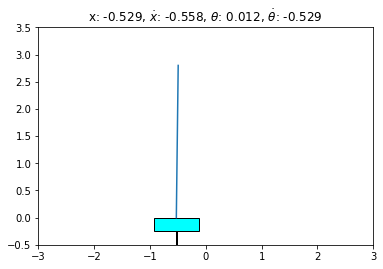

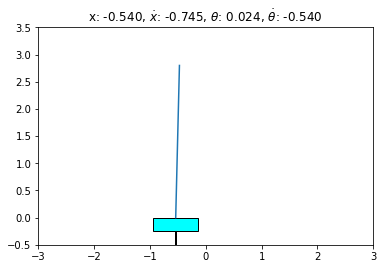

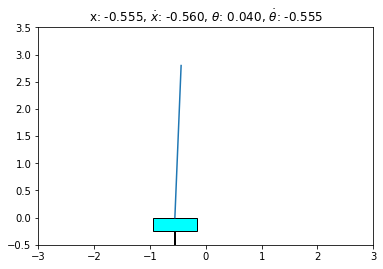

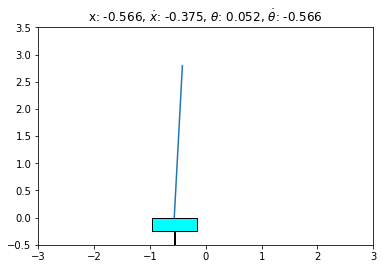

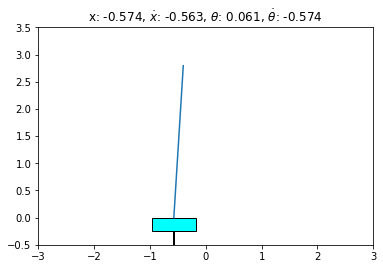

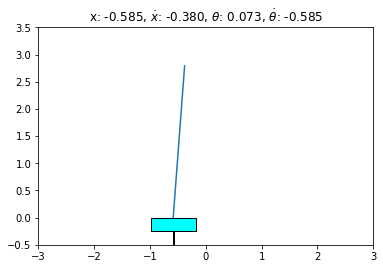

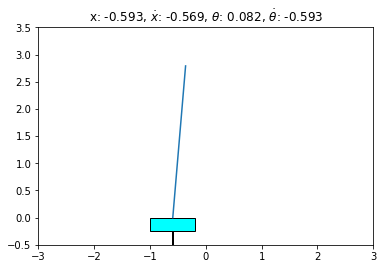

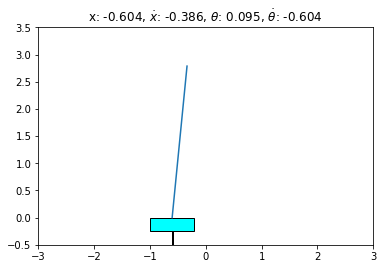

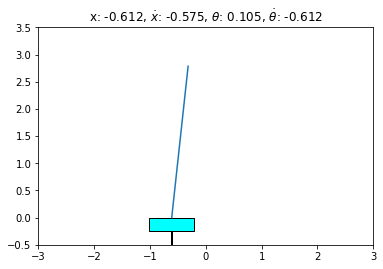

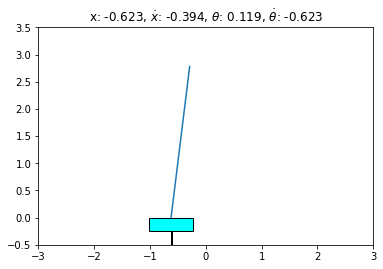

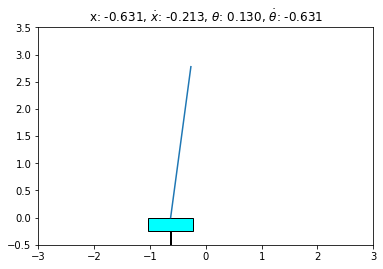

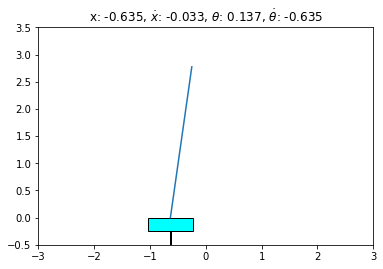

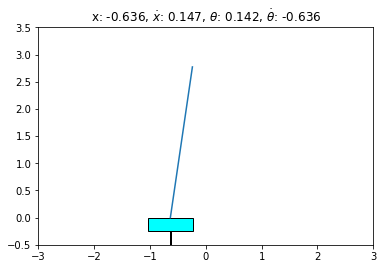

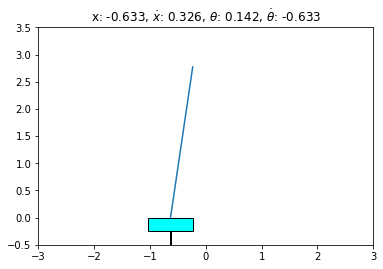

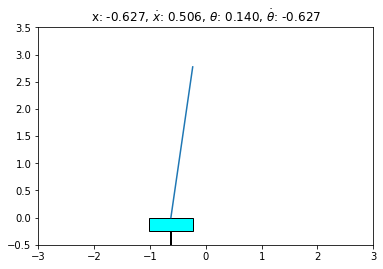

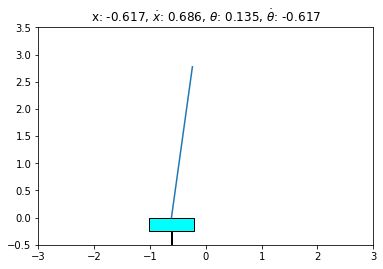

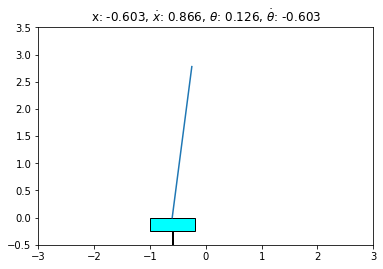

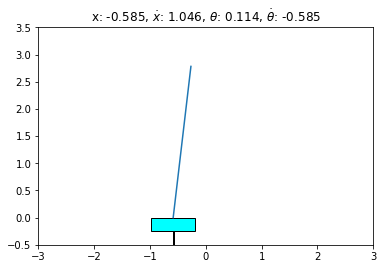

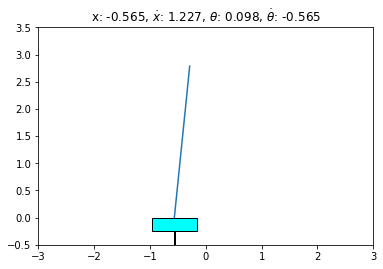

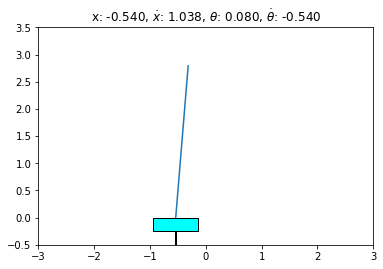

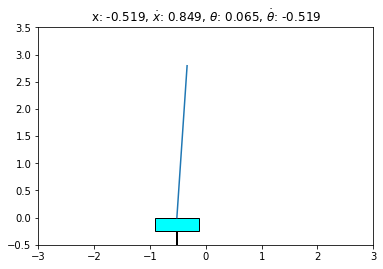

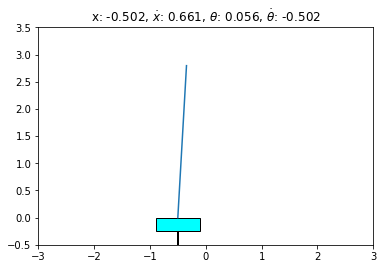

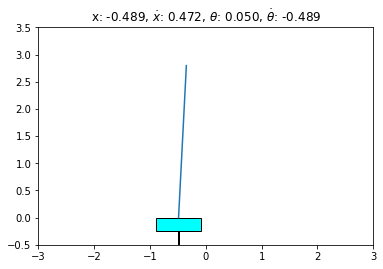

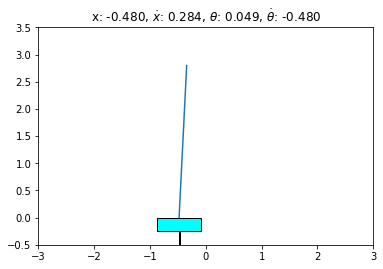

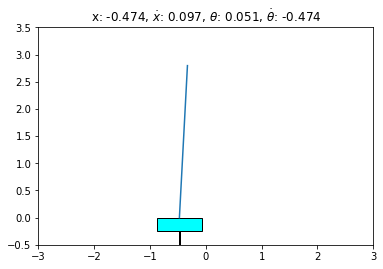

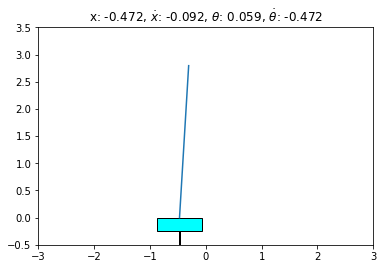

In [ ]:
"""
CS 229 Machine Learning, Fall 2017
Problem Set 4
Question: Reinforcement Learning: The inverted pendulum
Author: Sanyam Mehra, sanyam@stanford.edu
"""
from __future__ import division, print_function
from cart_pole import CartPole, Physics
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter

from collections import defaultdict

"""
Parts of the code (cart and pole dynamics, and the state
discretization) are inspired from code available at the RL repository
http://www-anw.cs.umass.edu/rlr/domains.html

This file controls the pole-balancing simulation. You only need to
write code in between places marked
###### BEGIN YOUR CODE ######
###### END YOUR CODE ######

Briefly, the cart-pole system is described in `cart_pole.py`. The main
simulation loop in this file calls the `simulate()` function for
simulating the pole dynamics, `get_state()` for discretizing the
otherwise continuous state space in discrete states, and `show_cart()`
for display.

Some useful parameters are listed below:

`NUM_STATES`: Number of states in the discretized state space
You must assume that states are numbered 0 through `NUM_STATES` - 1. The
state numbered `NUM_STATES` - 1 (the last one) is a special state that
marks the state when the pole has been judged to have fallen (or when
the cart is out of bounds). However, you should NOT treat this state
any differently in your code. Any distinctions you need to make between
states should come automatically from your learning algorithm.

After each simulation cycle, you are supposed to update the transition
counts and rewards observed. However, you should not change either
your value function or the transition probability matrix at each
cycle.

Whenever the pole falls, a section of your code below will be
executed. At this point, you must use the transition counts and reward
observations that you have gathered to generate a new model for the MDP
(i.e. transition probabilities and state rewards). After that, you
must use value iteration to get the optimal value function for this MDP
model.

`TOLERANCE`: Controls the convergence criteria for each value iteration
run. In value iteration, you can assume convergence when the maximum
absolute change in the value function at any state in an iteration
becomes lower than `TOLERANCE.

You need to write code that chooses the best action according
to your current value function, and the current model of the MDP. The
action must be either 0 or 1 (corresponding to possible directions of
pushing the cart)

Finally, we assume that the simulation has converged when
`NO_LEARNING_THRESHOLD` consecutive value function computations all
converged within one value function iteration. Intuitively, it seems
like there will be little learning after this, so we end the simulation
here, and say the overall algorithm has converged.


Learning curves can be generated by calling a code snippet at the end
(it assumes that the learning was just executed, and the array
`time_steps_to_failure` that records the time for which the pole was
balanced before each failure are in memory). `num_failures` is a variable
that stores the number of failures (pole drops / cart out of bounds)
till now.

Other parameters in the code are described below:

`GAMMA`: Discount factor to be used

The following parameters control the simulation display; you dont
really need to know about them:

`pause_time`: Controls the pause between successive frames of the
display. Higher values make your simulation slower.
`min_trial_length_to_start_display`: Allows you to start the display only
after the pole has been successfully balanced for at least this many
trials. Setting this to zero starts the display immediately. Choosing a
reasonably high value (around 100) can allow you to rush through the
initial learning quickly, and start the display only after the
performance is reasonable.
"""


# Simulation parameters
pause_time = 0.001
min_trial_length_to_start_display = 0
display_started = 1

NUM_STATES = 163
NUM_ACTIONS = 2
GAMMA = 0.995
TOLERANCE = 0.01
NO_LEARNING_THRESHOLD = 20

# Time cycle of the simulation
time = 0

# These variables perform bookkeeping (how many cycles was the pole
# balanced for before it fell). Useful for plotting learning curves.
time_steps_to_failure = []
num_failures = 0
time_at_start_of_current_trial = 0

# You should reach convergence well before this
max_failures = 500

# Initialize a cart pole
cart_pole = CartPole(Physics())

# Starting `state_tuple` is (0, 0, 0, 0)
# x, x_dot, theta, theta_dot represents the actual continuous state vector
x, x_dot, theta, theta_dot = 0.0, 0.0, 0.0, 0.0
state_tuple = (x, x_dot, theta, theta_dot)

# `state` is the number given to this state, you only need to consider
# this representation of the state
state = cart_pole.get_state(state_tuple)
# if min_trial_length_to_start_display == 0 or display_started == 1:
#     cart_pole.show_cart(state_tuple, pause_time)

# Perform all your initializations here:
# Assume no transitions or rewards have been observed.
# Initialize the value function array to small random values (0 to 0.10, say).
# Initialize the transition probabilities uniformly (ie, probability of
# transitioning for state x to state y using action a is exactly
# 1/NUM_STATES).
# Initialize all state rewards to zero.

###### BEGIN YOUR CODE ######
transition_record = np.zeros((NUM_STATES, NUM_ACTIONS, NUM_STATES))
reward_record = np.zeros(NUM_STATES)
reward_counts = np.zeros(NUM_STATES)

# init value function
value_func = np.random.rand(NUM_STATES)

# init transition probabilities
prob_sa = np.ones((NUM_STATES, NUM_ACTIONS, NUM_STATES)) / NUM_STATES

# init rewards
rewards = np.zeros(NUM_STATES)
###### END YOUR CODE ######

# This is the criterion to end the simulation.
# You should change it to terminate when the previous
# 'NO_LEARNING_THRESHOLD' consecutive value function computations all
# converged within one value function iteration. Intuitively, it seems
# like there will be little learning after this, so end the simulation
# here, and say the overall algorithm has converged.

consecutive_no_learning_trials = 0
while consecutive_no_learning_trials < NO_LEARNING_THRESHOLD:
    cart_pole.show_cart(state_tuple, pause_time)
    # Write code to choose action (0 or 1).
    # This action choice algorithm is just for illustration. It may
    # convince you that reinforcement learning is nice for control
    # problems!Replace it with your code to choose an action that is
    # optimal according to the current value function, and the current MDP
    # model.
    ###### BEGIN YOUR CODE ######
    action = np.argmax(np.sum(prob_sa[state] * value_func, axis=1))
    ###### END YOUR CODE ######

    # Get the next state by simulating the dynamics
    new_state_tuple = cart_pole.simulate(action, state_tuple)
    # x, x_dot, theta, theta_dot = state_tuple

    # Increment simulation time
    time = time + 1

    # Get the state number corresponding to new state vector
    new_state = cart_pole.get_state(new_state_tuple)
    # if display_started == 1:
    #     cart_pole.show_cart(state_tuple, pause_time)

    # reward function to use - do not change this!
    if new_state == NUM_STATES - 1:
        R = -1
    else:
        R = 0

    # Perform model updates here.
    # A transition from `state` to `new_state` has just been made using
    # `action`. The reward observed in `new_state` (note) is `R`.
    # Write code to update your statistics about the MDP i.e. the
    # information you are storing on the transitions and on the rewards
    # observed. Do not change the actual MDP parameters, except when the
    # pole falls (the next if block)!

    ###### BEGIN YOUR CODE ######
    # TODO:
    # raise NotImplementedError('Update T and R not implemented')
    transition_record[state, action, new_state] += 1
    reward_record[new_state] += R
    reward_counts[new_state] += 1

    # record the number of times `state, action, new_state` occurs
    # record the rewards for every `new_state`
    # record the number of time `new_state` was reached
    ###### END YOUR CODE ######

    # Recompute MDP model whenever pole falls
    # Compute the value function V for the new model
    if new_state == NUM_STATES - 1:
        # Update MDP model using the current accumulated statistics about the
        # MDP - transitions and rewards.
        # Make sure you account for the case when a state-action pair has never
        # been tried before, or the state has never been visited before. In that
        # case, you must not change that component (and thus keep it at the
        # initialized uniform distribution).

        ###### BEGIN YOUR CODE ######
        total = transition_record.sum(axis=2)
        mask = total > 0        # leave those unexperienced (s0, a) pairs put
        prob_sa[mask] = transition_record[mask] / total[mask].reshape(-1, 1)

        mask = reward_counts > 0
        rewards[mask] = reward_record[mask] / reward_counts[mask]
        ###### END YOUR CODE ######

        # Perform value iteration using the new estimated model for the MDP.
        # The convergence criterion should be based on `TOLERANCE` as described
        # at the top of the file.
        # If it converges within one iteration, you may want to update your
        # variable that checks when the whole simulation must end.

        ###### BEGIN YOUR CODE ######
        # just initialze its value to be bigger than TOLERANCE
        count = 0
        while True:
            new_value_func = (
                rewards +
                GAMMA * np.max(np.sum(prob_sa * value_func, axis=2), axis=1)
            )
            delta = np.abs(new_value_func - value_func)
            max_delta = np.max(delta)
            value_func = new_value_func

            count += 1
            if max_delta < TOLERANCE:
                break

        if count == 1:
            # value function converged within one iteration
            consecutive_no_learning_trials += 1
        else:
            # reset
            consecutive_no_learning_trials = 0
        ###### END YOUR CODE ######

    # Do NOT change this code: Controls the simulation, and handles the case
    # when the pole fell and the state must be reinitialized.
    if new_state == NUM_STATES - 1:
        num_failures += 1
        if num_failures >= max_failures:
            break
        print('[INFO] Failure number {}'.format(num_failures))
        time_steps_to_failure.append(time - time_at_start_of_current_trial)
        # time_steps_to_failure[num_failures] = time - time_at_start_of_current_trial
        time_at_start_of_current_trial = time

        if time_steps_to_failure[num_failures - 1] > min_trial_length_to_start_display:
            display_started = 1

        # Reinitialize state
        # x = 0.0
        x = -1.1 + np.random.uniform() * 2.2
        x_dot, theta, theta_dot = 0.0, 0.0, 0.0
        state_tuple = (x, x_dot, theta, theta_dot)
        state = cart_pole.get_state(state_tuple)
    else:
        state = new_state
        state_tuple = new_state_tuple

# plot the learning curve (time balanced vs. trial)
log_tstf = np.log(np.array(time_steps_to_failure))
plt.plot(np.arange(len(time_steps_to_failure)), log_tstf, 'k')
window = 30
w = np.array([1/window for _ in range(window)])
weights = lfilter(w, 1, log_tstf)
x = np.arange(window//2, len(log_tstf) - window//2)
plt.plot(x, weights[window:len(log_tstf)], 'r--')
plt.xlabel('Num failures')
plt.ylabel('Num steps to failure')
plt.show()
